#### To use the Random Forest Survival analysis you will need to use the Pysurvival package.
To install this package please follow the instructions from this site https://square.github.io/pysurvival/installation.html
##### For MacOS users:
You will need to add two more lines besides the recommended 2 as shown below:
###### Note: please check which version of gcc do you have as it might be different from 9.3.0.



### To use the Random Forest Survival analysis we need to load the data and remove the colinear features

In [67]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pysurvival.utils.display import correlation_matrix

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sns.set()
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

### using the panda reader import your file where the data is contained

In [148]:
# clinical_data=pd.read_excel('clin_data_dim1_only.xlsx')
clinical_data = pd.read_csv('liver_sub_gtv.csv')

clinical_data

,Unnamed: 0,filename,FFLP,FFLP_in_months,diagnostics_Image-original_Mean,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,0,18284004043,0.0,0.8,-650.732860,0.603414,0.429366,90.057300,209.744909,191.255708,...,496.996658,0.002853,6.661959,0.224866,1.792861e+05,94.229459,0.000005,2901.240190,0.035151,0.007150
1,1,18541330675,0.0,4.2,-785.011777,0.914913,0.703803,114.499498,162.686931,197.838866,...,300.212863,0.009806,7.823879,0.033573,7.360884e+06,59.579096,0.000007,820.770024,0.005038,0.019136
2,2,20243743626,0.0,1.1,-729.302957,0.780417,0.629166,86.815419,137.984998,149.592559,...,518.056125,0.004935,7.367605,0.159763,1.673962e+05,38.666531,0.000012,2126.663835,0.046318,0.016631
3,3,20444767425,1.0,36.3,-677.740532,0.594246,0.508212,97.619877,192.085068,218.874247,...,477.402285,0.004729,7.337764,0.120399,8.021512e+05,61.666741,0.000007,1812.545877,0.036305,0.012660
4,4,20525126502,1.0,2.0,-746.867222,0.623688,0.370911,90.142263,243.029535,295.673080,...,342.913715,0.007161,7.647863,0.106963,6.796121e+05,56.633008,0.000008,1453.121265,0.028608,0.013666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,79,211310175445,1.0,3.8,-680.216740,0.647283,0.442654,96.741168,218.548051,235.336502,...,540.386597,0.001499,6.978312,0.076582,1.838635e+06,66.740238,0.000006,1501.445496,0.012913,0.013103
80,80,211401772640,1.0,9.5,-817.325833,0.768082,0.587806,105.218667,179.002479,188.250562,...,428.458071,0.003594,7.466738,0.064335,2.256018e+06,54.886843,0.000008,1138.590654,0.011888,0.017067
81,81,211502540723,1.0,4.4,-698.505549,0.805310,0.596997,111.338383,186.497245,229.178770,...,445.994521,0.004087,7.606840,0.068773,2.760389e+06,65.672119,0.000006,1282.069251,0.013748,0.014702
82,82,211545340988,1.0,13.1,-690.970603,0.667473,0.381260,92.482554,242.570822,258.686219,...,293.909153,0.004641,6.807994,0.066692,3.289728e+06,109.534480,0.000004,1355.549751,0.007659,0.009933


In [149]:
# originally this step manually removes excluded rows, but this was done beforehand already
data=clinical_data.drop([]).reset_index(drop=True)

data.columns

Index(['Unnamed: 0', 'filename', 'FFLP', 'FFLP_in_months',
       'diagnostics_Image-original_Mean', 'original_shape_Elongation',
       'original_shape_Flatness', 'original_shape_LeastAxisLength',
       'original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameterColumn',
       ...
       'original_glszm_SmallAreaHighGrayLevelEmphasis',
       'original_glszm_SmallAreaLowGrayLevelEmphasis',
       'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage',
       'original_glszm_ZoneVariance', 'original_ngtdm_Busyness',
       'original_ngtdm_Coarseness', 'original_ngtdm_Complexity',
       'original_ngtdm_Contrast', 'original_ngtdm_Strength'],
      dtype='object', length=112)

In [150]:
data['time column']=clinical_data['FFLP_in_months']
data['event column']=clinical_data['FFLP']
data

,Unnamed: 0,filename,FFLP,FFLP_in_months,diagnostics_Image-original_Mean,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,...,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,time column,event column
0,0,18284004043,0.0,0.8,-650.732860,0.603414,0.429366,90.057300,209.744909,191.255708,...,6.661959,0.224866,1.792861e+05,94.229459,0.000005,2901.240190,0.035151,0.007150,0.8,0.0
1,1,18541330675,0.0,4.2,-785.011777,0.914913,0.703803,114.499498,162.686931,197.838866,...,7.823879,0.033573,7.360884e+06,59.579096,0.000007,820.770024,0.005038,0.019136,4.2,0.0
2,2,20243743626,0.0,1.1,-729.302957,0.780417,0.629166,86.815419,137.984998,149.592559,...,7.367605,0.159763,1.673962e+05,38.666531,0.000012,2126.663835,0.046318,0.016631,1.1,0.0
3,3,20444767425,1.0,36.3,-677.740532,0.594246,0.508212,97.619877,192.085068,218.874247,...,7.337764,0.120399,8.021512e+05,61.666741,0.000007,1812.545877,0.036305,0.012660,36.3,1.0
4,4,20525126502,1.0,2.0,-746.867222,0.623688,0.370911,90.142263,243.029535,295.673080,...,7.647863,0.106963,6.796121e+05,56.633008,0.000008,1453.121265,0.028608,0.013666,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,79,211310175445,1.0,3.8,-680.216740,0.647283,0.442654,96.741168,218.548051,235.336502,...,6.978312,0.076582,1.838635e+06,66.740238,0.000006,1501.445496,0.012913,0.013103,3.8,1.0
80,80,211401772640,1.0,9.5,-817.325833,0.768082,0.587806,105.218667,179.002479,188.250562,...,7.466738,0.064335,2.256018e+06,54.886843,0.000008,1138.590654,0.011888,0.017067,9.5,1.0
81,81,211502540723,1.0,4.4,-698.505549,0.805310,0.596997,111.338383,186.497245,229.178770,...,7.606840,0.068773,2.760389e+06,65.672119,0.000006,1282.069251,0.013748,0.014702,4.4,1.0
82,82,211545340988,1.0,13.1,-690.970603,0.667473,0.381260,92.482554,242.570822,258.686219,...,6.807994,0.066692,3.289728e+06,109.534480,0.000004,1355.549751,0.007659,0.009933,13.1,1.0


In [151]:
data1=data.drop(columns=['filename', 'Unnamed: 0'])
data1.to_csv('for_survival.csv')
lola=data1.iloc[:,0:255]
lola.columns

Index(['FFLP', 'FFLP_in_months', 'diagnostics_Image-original_Mean',
       'original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice',
       ...
       'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage',
       'original_glszm_ZoneVariance', 'original_ngtdm_Busyness',
       'original_ngtdm_Coarseness', 'original_ngtdm_Complexity',
       'original_ngtdm_Contrast', 'original_ngtdm_Strength', 'time column',
       'event column'],
      dtype='object', length=112)

In [152]:
time_column='time column'
event_column='event column'
features=np.setdiff1d(data1.columns, [time_column, event_column]).tolist()
features

['FFLP',
 'FFLP_in_months',
 'diagnostics_Image-original_Mean',
 'original_firstorder_10Percentile',
 'original_firstorder_90Percentile',
 'original_firstorder_Energy',
 'original_firstorder_Entropy',
 'original_firstorder_InterquartileRange',
 'original_firstorder_Kurtosis',
 'original_firstorder_Maximum',
 'original_firstorder_Mean',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Median',
 'original_firstorder_Minimum',
 'original_firstorder_Range',
 'original_firstorder_RobustMeanAbsoluteDeviation',
 'original_firstorder_RootMeanSquared',
 'original_firstorder_Skewness',
 'original_firstorder_TotalEnergy',
 'original_firstorder_Uniformity',
 'original_firstorder_Variance',
 'original_glcm_Autocorrelation',
 'original_glcm_ClusterProminence',
 'original_glcm_ClusterShade',
 'original_glcm_ClusterTendency',
 'original_glcm_Contrast',
 'original_glcm_Correlation',
 'original_glcm_DifferenceAverage',
 'original_glcm_DifferenceEntropy',
 'original_glcm_DifferenceVari

### We will be using Variance Inflation Factor to remove the colinear features
In the RFS analysis it is very important to remove the colinear features

In [153]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=20.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [154]:
lola

,FFLP,FFLP_in_months,diagnostics_Image-original_Mean,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,...,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,time column,event column
0,0.0,0.8,-650.732860,0.603414,0.429366,90.057300,209.744909,191.255708,183.420004,223.230565,...,6.661959,0.224866,1.792861e+05,94.229459,0.000005,2901.240190,0.035151,0.007150,0.8,0.0
1,0.0,4.2,-785.011777,0.914913,0.703803,114.499498,162.686931,197.838866,188.134021,185.535103,...,7.823879,0.033573,7.360884e+06,59.579096,0.000007,820.770024,0.005038,0.019136,4.2,0.0
2,0.0,1.1,-729.302957,0.780417,0.629166,86.815419,137.984998,149.592559,156.680268,128.297832,...,7.367605,0.159763,1.673962e+05,38.666531,0.000012,2126.663835,0.046318,0.016631,1.1,0.0
3,1.0,36.3,-677.740532,0.594246,0.508212,97.619877,192.085068,218.874247,134.694018,217.187578,...,7.337764,0.120399,8.021512e+05,61.666741,0.000007,1812.545877,0.036305,0.012660,36.3,1.0
4,1.0,2.0,-746.867222,0.623688,0.370911,90.142263,243.029535,295.673080,187.482228,286.259730,...,7.647863,0.106963,6.796121e+05,56.633008,0.000008,1453.121265,0.028608,0.013666,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,1.0,3.8,-680.216740,0.647283,0.442654,96.741168,218.548051,235.336502,171.996802,248.921462,...,6.978312,0.076582,1.838635e+06,66.740238,0.000006,1501.445496,0.012913,0.013103,3.8,1.0
80,1.0,9.5,-817.325833,0.768082,0.587806,105.218667,179.002479,188.250562,183.230814,215.851911,...,7.466738,0.064335,2.256018e+06,54.886843,0.000008,1138.590654,0.011888,0.017067,9.5,1.0
81,1.0,4.4,-698.505549,0.805310,0.596997,111.338383,186.497245,229.178770,202.040396,195.963426,...,7.606840,0.068773,2.760389e+06,65.672119,0.000006,1282.069251,0.013748,0.014702,4.4,1.0
82,1.0,13.1,-690.970603,0.667473,0.381260,92.482554,242.570822,258.686219,250.498326,213.569032,...,6.807994,0.066692,3.289728e+06,109.534480,0.000004,1355.549751,0.007659,0.009933,13.1,1.0


In [155]:
#VIF of 10 means that all the features with R^2 above 0.9 will removed
X = lola
data2 = calculate_vif_(X, 10)

dropping 'original_firstorder_Energy' at index: 19
dropping 'original_glcm_SumSquares' at index: 57
dropping 'original_glszm_LargeAreaEmphasis' at index: 91
dropping 'original_firstorder_Range' at index: 27
dropping 'time column' at index: 106
dropping 'original_glcm_JointAverage' at index: 49
dropping 'original_firstorder_TotalEnergy' at index: 30
dropping 'original_shape_MeshVolume' at index: 11
dropping 'original_firstorder_Entropy' at index: 18
dropping 'original_shape_VoxelVolume' at index: 15
dropping 'original_firstorder_Variance' at index: 28
dropping 'original_firstorder_Mean' at index: 21
dropping 'original_glrlm_HighGrayLevelRunEmphasis' at index: 66
dropping 'original_glcm_Autocorrelation' at index: 27
dropping 'original_firstorder_RootMeanSquared' at index: 24
dropping 'original_glcm_Idm' at index: 35
dropping 'original_glcm_Id' at index: 34
dropping 'original_glszm_LargeAreaHighGrayLevelEmphasis' at index: 78
dropping 'FFLP' at index: 0
dropping 'original_shape_SurfaceVol

In [156]:
data2_temp = data2

In [157]:
#This looked like it was manually extracting the non-colinear features
#Commented out, instead, I am using the retun value from the calculate_vif_ function
#creating a new dataframe with colinear features removed
#data2=data1.loc[:, ['LBP94', 'LBP101', 'LBP106', 'LBP107', 'LBP108', 'LBP112', 'LBP116',
#       'LBP118', 'LBP119', 'LBP120', 'FD27', 'FD51', 'FD54', 'ACM1_12', 'time column', 'event column']]
#data2


data2[['time column']] = lola[['time column']]
data2

,FFLP_in_months,original_firstorder_Skewness,original_glcm_ClusterProminence,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_ngtdm_Strength,event column,time column
0,0.8,-1.005554,18299.880589,12505.351803,233.388706,0.003656,127401.861057,0.007150,0.0,0.8
1,4.2,-1.996441,13540.164449,73405.625235,11042.403564,0.013132,17583.874266,0.019136,0.0,4.2
2,1.1,-1.038593,59596.298112,22253.020698,188.015247,0.006340,47882.755723,0.016631,0.0,1.1
3,36.3,-2.248061,104603.204600,33996.257452,794.846164,0.007311,57072.098496,0.012660,1.0,36.3
4,2.0,-1.239299,67360.496068,32609.213861,869.856028,0.010218,48205.449121,0.013666,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...
79,3.8,-1.044032,18439.625454,43944.711227,1866.859397,0.002031,40386.515882,0.013103,1.0,3.8
80,9.5,-0.757732,35045.382667,57084.204964,2768.296245,0.004836,30935.864382,0.017067,1.0,9.5
81,4.4,-1.932165,38759.021911,65760.862633,2784.069941,0.005477,35167.562021,0.014702,1.0,4.4
82,13.1,-2.236008,9872.615831,29445.609015,5482.460113,0.006650,40622.564996,0.009933,1.0,13.1


In [158]:
#create a dataframe with time and event columns
time_column='time column'
event_column='event column'
features=np.setdiff1d(data2.columns, [time_column, event_column]).tolist()
len(features)
features

['FFLP_in_months',
 'original_firstorder_Skewness',
 'original_glcm_ClusterProminence',
 'original_gldm_LargeDependenceHighGrayLevelEmphasis',
 'original_glszm_LargeAreaLowGrayLevelEmphasis',
 'original_glszm_LowGrayLevelZoneEmphasis',
 'original_glszm_SizeZoneNonUniformity',
 'original_ngtdm_Strength']

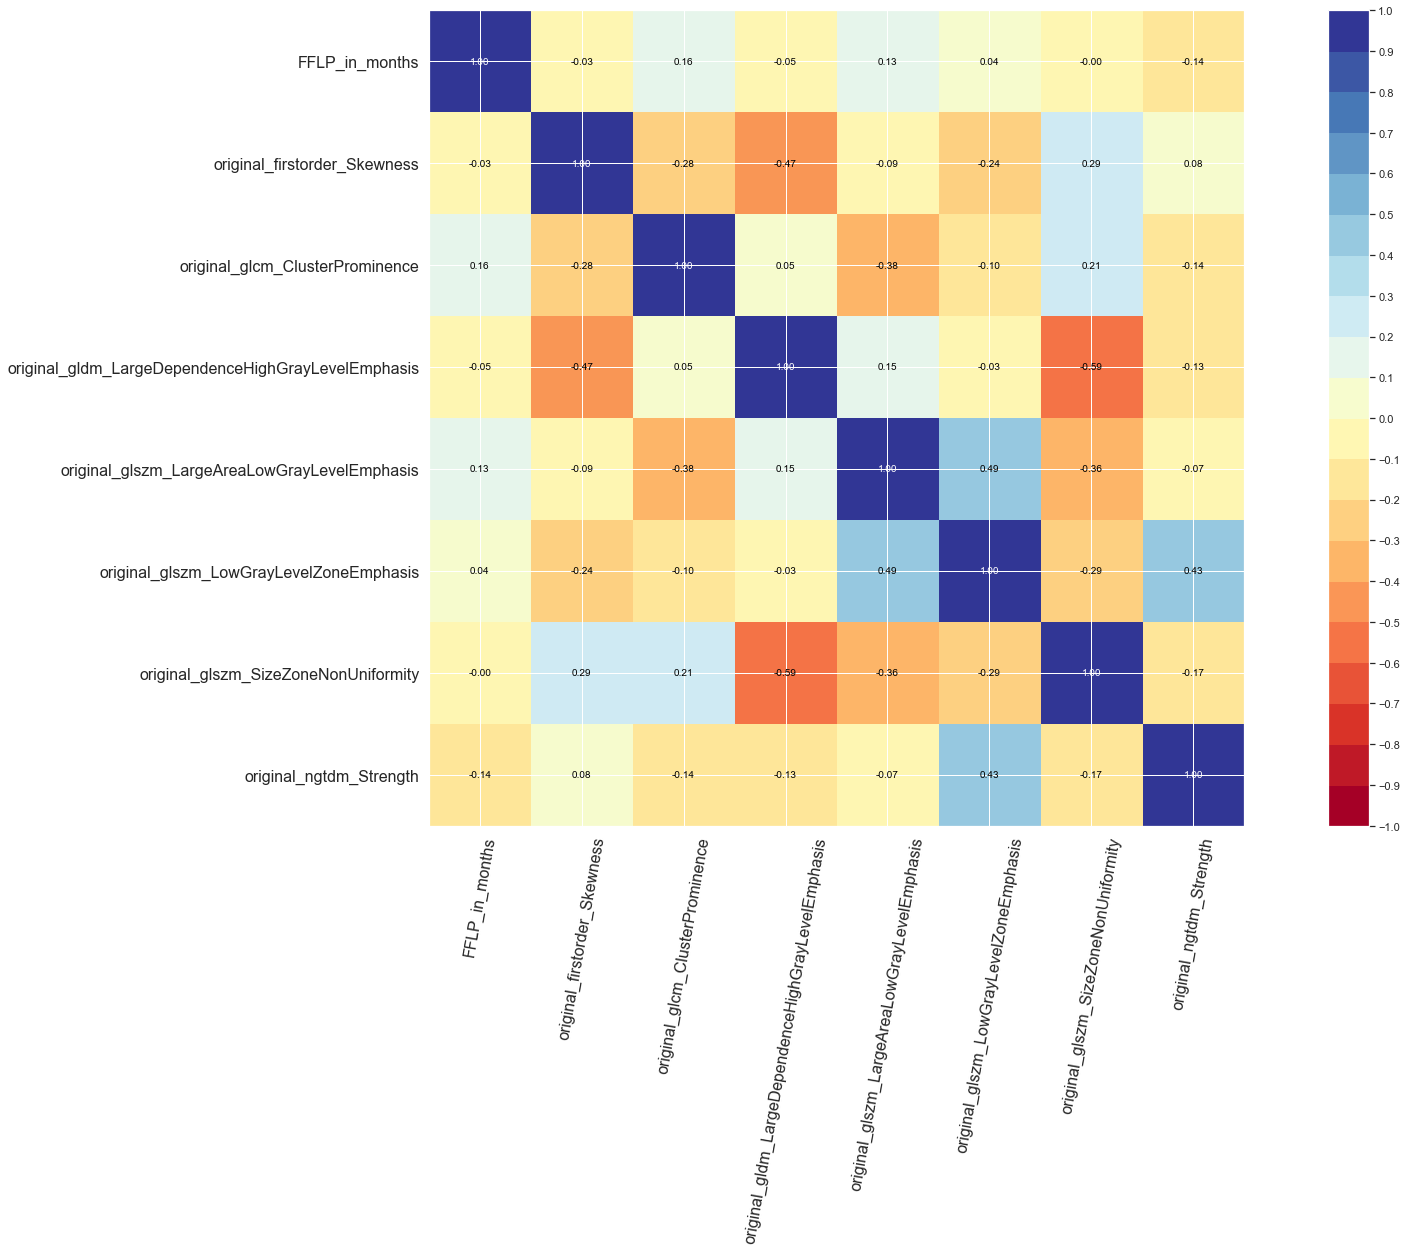

In [159]:
#visualize the full correlation matrix, optional

correlation_matrix(data2_temp[features], figure_size=(30,15), text_fontsize=10)

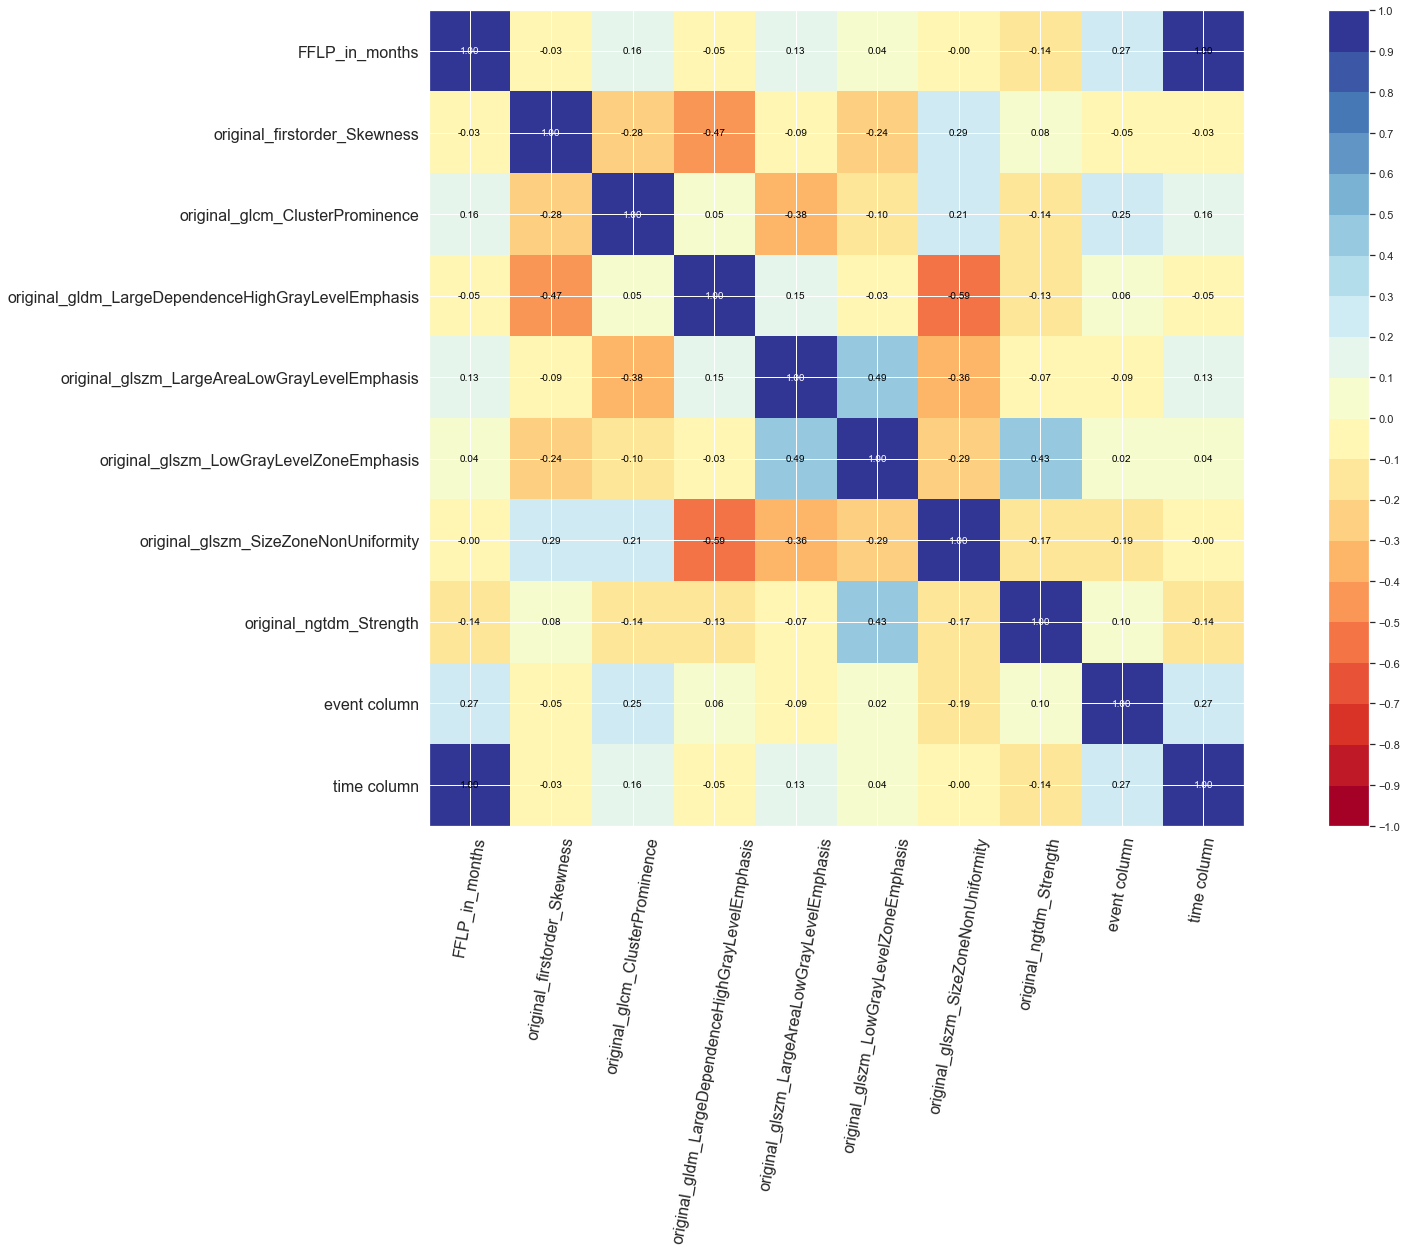

In [160]:
#removing low variance features
data_temp = data2

for cols in data2.columns:
    if np.var(data2[cols]) == 0:
        print('Dropping: ' + cols)
        data_temp = data_temp.drop(columns=cols)

data2 = data_temp
features=np.setdiff1d(data2.columns, [time_column, event_column]).tolist()
correlation_matrix(data2, figure_size=(30,15), text_fontsize=10)

#### Now we are ready to analyze our data 
 we need to define our input (X), time (T) and event (E) columns


In [161]:
# Creating the X, T and E inputs
X = data2[features]

newX=np.setdiff1d(data2.columns, [ event_column]).tolist()
X=data2[newX]
E=data2['event column']

#### Now we can gridsearch for optimal hyperparameters, also decreasing K-folds to 5 due to sample size

In [162]:
num_tree=(10, 15, 20, 50, 100, 200)
max_depth=(1, 2, 3, 5, 10, 12, 15)
min_node=(1, 2, 3, 5, 10, 12)


In [163]:
# this script searches the RF paramters listed in the cell 29
#prints out the average of 10 K Fold concordance
# originally, this used Xnew from the 3 extracted features
# but this was changed for this dataset
from sklearn.model_selection import StratifiedKFold
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from statistics import mean 

Xnew = X
Enew = E
features2 = features

for a in num_tree:
    for b in max_depth:
        for c in min_node:
            cc=[]
            kf=StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
            i=1
            for train_index, test_index in kf.split(Xnew,Enew):
                X1_train, X1_test=Xnew.loc[train_index], Xnew.loc[test_index]
                X_train, X_test=X1_train[features2], X1_test[features2]
                T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
                E_train, E_test=Enew.loc[train_index].values, Enew.loc[test_index].values
                xst = RandomSurvivalForestModel(num_trees=a) 
                xst.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = b,
                min_node_size = c, num_threads = -1, 
                sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
                seed = None, save_memory=False )
                from pysurvival.utils.metrics import concordance_index
                c_index = concordance_index(xst, X_test, T_test, E_test)
                cc.append(c_index)
                i=i+1
            print(a,b, c, mean(cc))
                 

10 1 1 0.6558433316664432
10 1 2 0.6255437731717363
10 1 3 0.6000511624066769
10 1 5 0.6531820232950807
10 1 10 0.604996251992471
10 1 12 0.7129000713031433
10 2 1 0.7261792363569217
10 2 2 0.6425615432927689
10 2 3 0.6218788797050017
10 2 5 0.744061165848798
10 2 10 0.7338084298639046
10 2 12 0.6901691764223616
10 3 1 0.7583950581004534
10 3 2 0.6426682593831538
10 3 3 0.7412480652406482
10 3 5 0.6266142888762881
10 3 10 0.7411854070313596
10 3 12 0.695153299286943
10 5 1 0.6969513392166893
10 5 2 0.7203457560195022
10 5 3 0.6819076673666831
10 5 5 0.670077310371294
10 5 10 0.745944264671184
10 5 12 0.7123822744848061
10 10 1 0.6822285639099617
10 10 2 0.7100529474438645
10 10 3 0.6867150860527111
10 10 5 0.7435632521613728
10 10 10 0.7367061939903681
10 10 12 0.7324093542482506
10 12 1 0.7438162430233534
10 12 2 0.7066213449040819
10 12 3 0.6669625243184485
10 12 5 0.7068014505857013
10 12 10 0.7643164867030241
10 12 12 0.7541052941423666
10 15 1 0.6856622541860143
10 15 2 0.66474388


 1 of kfold 5


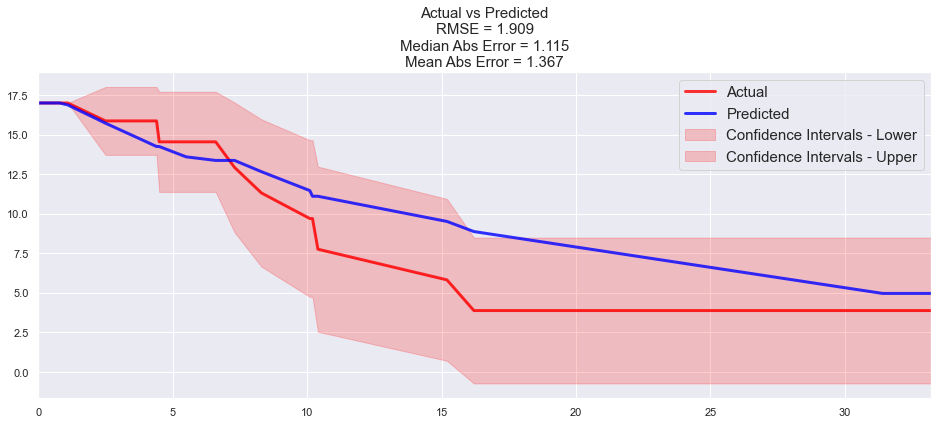

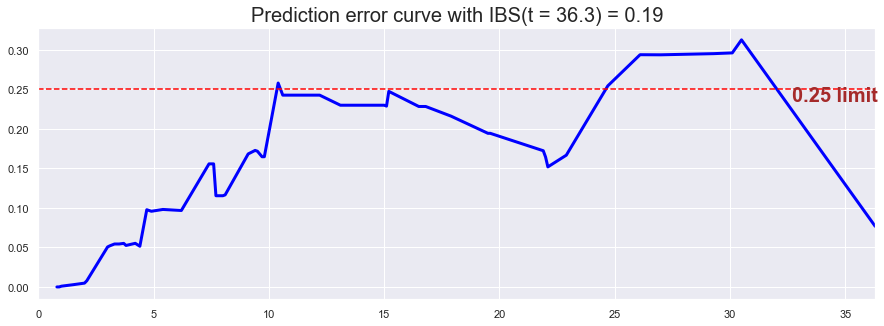

C-index: 0.78
IBS: 0.19

 2 of kfold 5


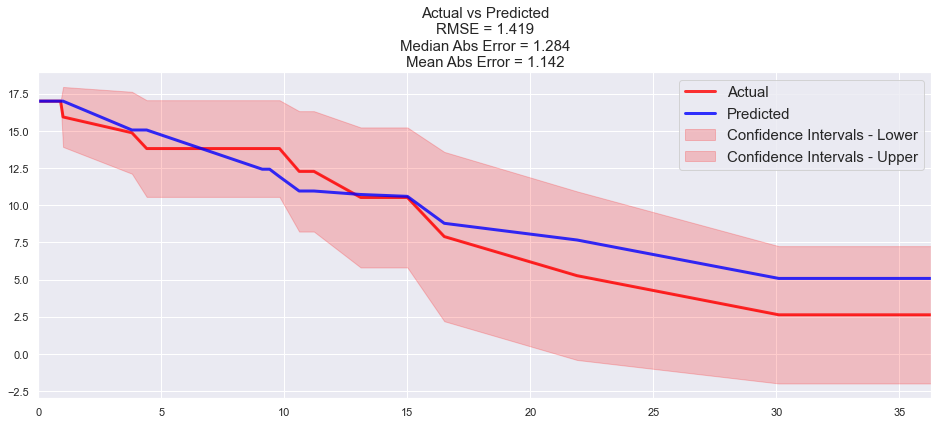

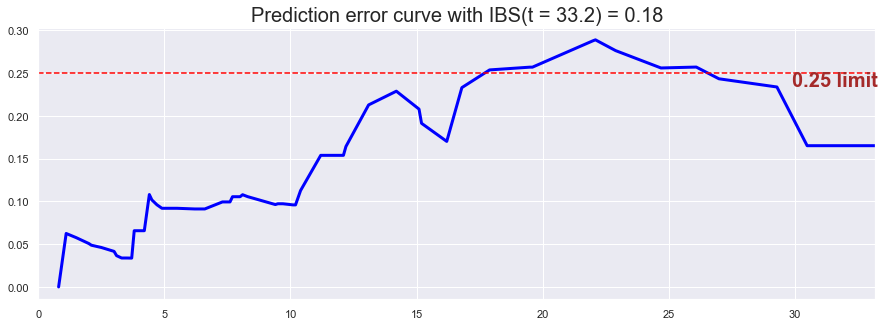

C-index: 0.65
IBS: 0.18

 3 of kfold 5


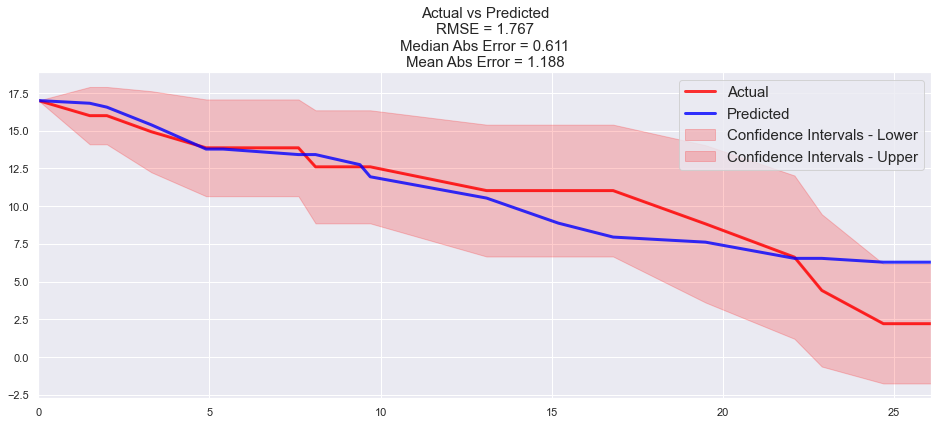

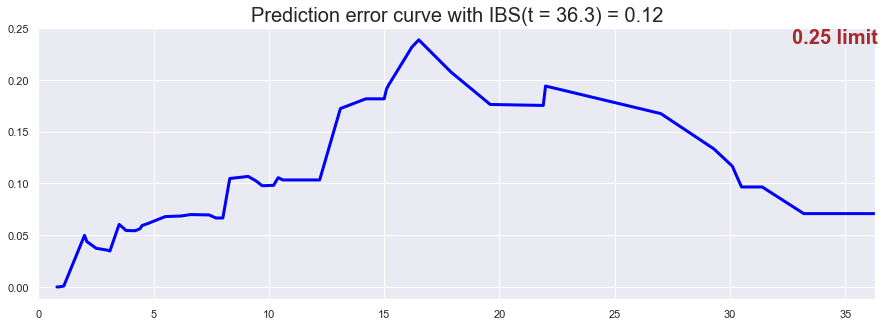

C-index: 0.80
IBS: 0.12

 4 of kfold 5


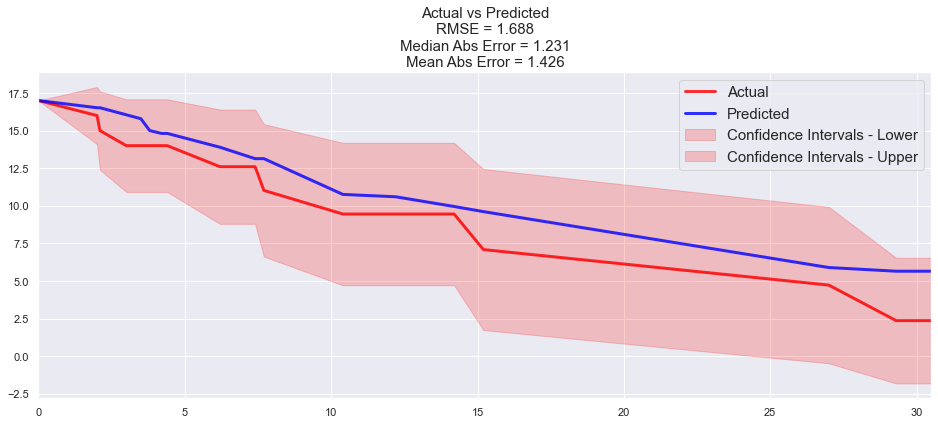

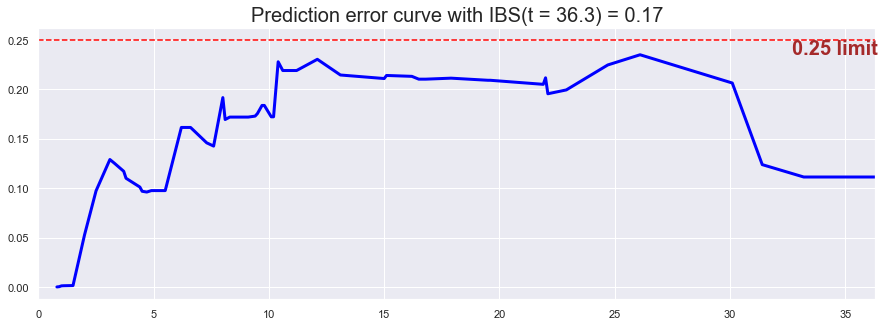

C-index: 0.64
IBS: 0.17

 5 of kfold 5


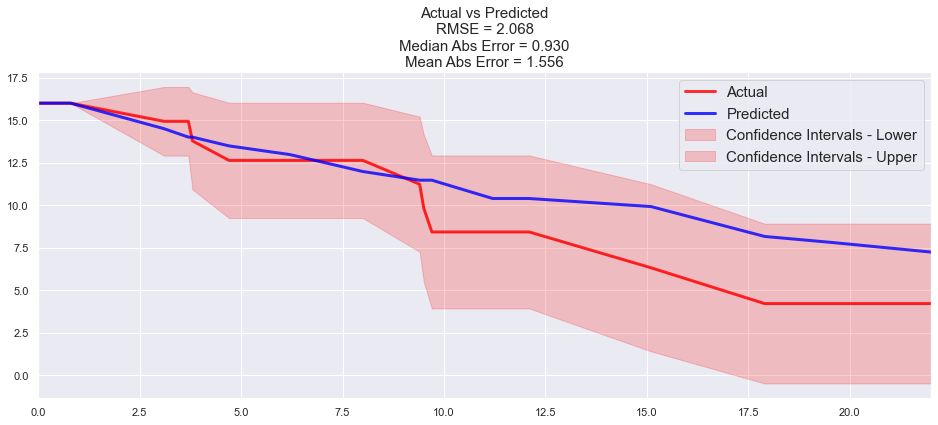

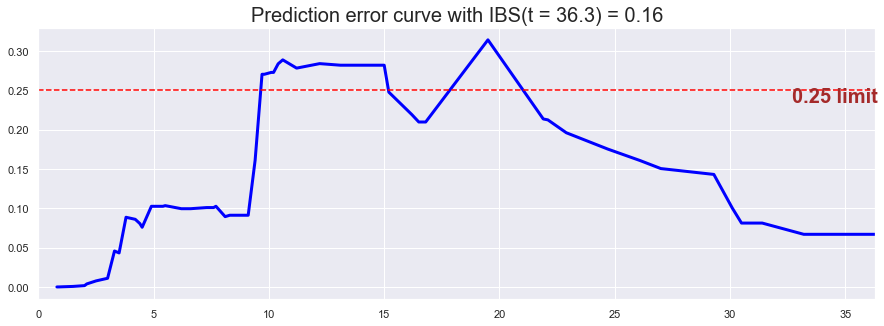

C-index: 0.70
IBS: 0.16


In [130]:
# retraining with best gridsearch hyperparameters, manually entering them as variables, probably can automate this from picking out max acc

# Creating the X, T and E inputs
X = data2[features]

newX=np.setdiff1d(data2.columns, [ event_column]).tolist()
X=data2[newX]
E=data2['event column']

CI = []
IBS = []
best_num_tree = 15
best_depth = 12
best_min_node = 5
k_folds = 5
from sklearn.model_selection import StratifiedKFold
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import compare_to_actual
from pysurvival.utils.display import integrated_brier_score
i=1
kf=StratifiedKFold(n_splits=k_folds, random_state=1, shuffle=True)
for train_index, test_index in kf.split(X,E):
    print('\n {} of kfold {}'.format(i,kf.n_splits)) 
    X1_train, X1_test=X.loc[train_index], X.loc[test_index]
    X_train, X_test=X1_train[features], X1_test[features]
    T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
    E_train, E_test=E.loc[train_index].values, E.loc[test_index].values
    xst = RandomSurvivalForestModel(num_trees=best_num_tree) 
    xst.fit(X_train, T_train, E_train, max_features = 'sqrt', max_depth = best_depth,
        min_node_size = best_min_node, num_threads = -1, 
        sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
        seed = None, save_memory=False )
    c_index = concordance_index(xst, X_test, T_test, E_test)
    
    results = compare_to_actual(xst, X_test, T_test, E_test, is_at_risk = True,  figure_size=(16, 6), 
                                metrics = ['rmse', 'mean', 'median'])
    ibs = integrated_brier_score(xst, X_test, T_test, E_test, t_max=100, figure_size=(15,5))
    CI.append(c_index)
    IBS.append(ibs)
    print('C-index: {:.2f}'.format(c_index))
    print('IBS: {:.2f}'.format(ibs))
    i=i+1

In [131]:
print(CI)
print(IBS)

[0.776414831881571, 0.6536402830596071, 0.8031490667909115, 0.6369372329937563, 0.6992823283281695]
[0.18686666414405065, 0.17664671690316894, 0.12398458049343118, 0.1702398321844484, 0.15694482175025562]


In [58]:
xst.variable_importance_table.head(20)


,feature,importance,pct_importance
0,original_glrlm_LongRunLowGrayLevelEmphasis,1.877480,0.106444
1,original_firstorder_Maximum,1.829604,0.103729
2,original_shape_Maximum2DDiameterSlice,1.667590,0.094544
3,original_firstorder_Variance,1.549064,0.087824
4,original_firstorder_Kurtosis,1.521446,0.086258
5,original_firstorder_InterquartileRange,1.483783,0.084123
6,original_gldm_DependenceVariance,1.270569,0.072035
7,original_firstorder_Minimum,1.252106,0.070988
8,original_shape_SurfaceVolumeRatio,1.175887,0.066667
9,original_firstorder_TotalEnergy,1.162897,0.065930


In [39]:
# getting sample predictions


preds = xst.predict_survival(data1.iloc[:,:-2].transpose())
preds_df = pd.DataFrame(preds).T
preds_df.to_excel('preds.xlsx')

In [64]:
def selection_sort(x):
    for i in range(len(x)):
        swap = i + np.argmin(x[i:])
        (x[i], x[swap]) = (x[swap], x[i])
    return x

preds = pd.DataFrame(columns = ['Preds','Actual'])
preds['Preds'] = xst.times
actuals = selection_sort(data2['time column'])
preds['Actual'] = data2['time column']
print(preds)


    Preds  Actual
0    -2.4    -2.4
1    -1.8    -1.8
2    -1.4    -1.4
3    -0.9    -0.9
4     0.8     0.8
5     0.9     0.8
6     1.0     0.9
7     1.1     1.0
8     1.5     1.1
9     1.9     1.5
10    2.0     1.9
11    2.1     2.0
12    2.5     2.1
13    3.0     2.1
14    3.3     2.5
15    3.5     3.0
16    3.8     3.1
17    4.4     3.3
18    4.5     3.5
19    4.9     3.8
20    5.5     3.8
21    6.2     3.8
22    6.6     3.8
23    7.3     4.4
24    7.4     4.4
25    7.7     4.4
26    8.0     4.5
27    8.1     4.7
28    8.3     4.9
29    9.4     5.5
30    9.8     6.2
31   10.1     6.2
32   10.2     6.4
33   10.4     6.6
34   10.6     7.3
35   11.2     7.4
36   12.1     7.6
37   13.1     7.7
38   14.2     8.0
39   15.2     8.1
40   16.2     8.3
41   16.5     9.1
42   16.8     9.4
43   19.5     9.4
44   19.6     9.4
45   21.9     9.4
46   22.1     9.5
47   22.9     9.8
48   24.7    10.1
49   26.1    10.2
50   27.0    10.4
51   29.3    10.4
52   30.1    10.6
53   30.5    11.2
54   31.4 

3.494355248975368e-10